# Bayesian Optimization of DMAC and RSI

This notebook compares two widely used trading strategies — the Double Moving Average Crossover (DMAC) and the RSI Mean Reversion — by optimizing their parameters using Bayesian Optimization. It walks through the entire process: data acquisition, backtesting, parameter tuning, and out-of-sample evaluation. Visualizations and performance metrics reveal which approach performed best, including a benchmark comparison against Buy & Hold. All results are based on historical data for MSFT from 2020 to 2025.

## Import Libraries

In [ ]:
%pip install yfinance matplotlib pandas bayesian-optimization

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import matplotlib.dates as mdates
import numpy as np
plt.style.use("dark_background")

## Parameters

In [150]:
# Parameters
ticker = "MSFT"
start_date = "2020-01-01"
end_date = "2025-06-30"
train_cutoff_date = "2023-12-31"
initial_capital = 10

## Download Data and Prepare Splits

In [151]:
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.columns = df.columns.get_level_values(0)
df = df[['Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-02,153.042313
2020-01-03,151.136658
2020-01-06,151.527328
2020-01-07,150.145737
2020-01-08,152.537308


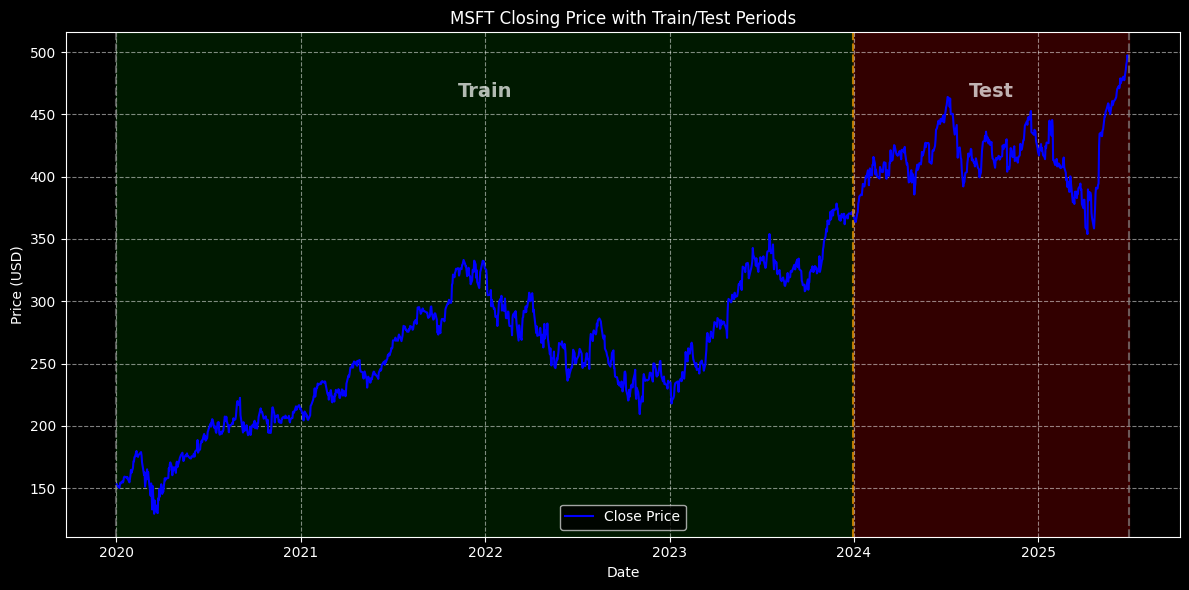

In [152]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')

# Convert string dates to datetime
start_dt = pd.to_datetime(start_date)
train_cutoff_dt = pd.to_datetime(train_cutoff_date)
end_dt = pd.to_datetime(end_date)

# Vertical cutoff lines
plt.axvline(start_dt, color='gray', linestyle='--', alpha=0.7)
plt.axvline(train_cutoff_dt, color='orange', linestyle='--', alpha=0.7)
plt.axvline(end_dt, color='gray', linestyle='--', alpha=0.7)

# Highlight train and test regions
plt.axvspan(start_dt, train_cutoff_dt, color='green', alpha=0.2)
plt.axvspan(train_cutoff_dt, end_dt, color='red', alpha=0.2)

# Text labels centered in train/test regions
train_mid = start_dt + (train_cutoff_dt - start_dt) / 2
test_mid = train_cutoff_dt + (end_dt - train_cutoff_dt) / 2
plt.text(train_mid, plt.ylim()[1]*0.9, 'Train', horizontalalignment='center', color='white', fontsize=14, fontweight='bold', alpha=0.7)
plt.text(test_mid, plt.ylim()[1]*0.9, 'Test', horizontalalignment='center', color='white', fontsize=14, fontweight='bold', alpha=0.7)

plt.title(f"{ticker} Closing Price with Train/Test Periods")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("closing_price_with_train_test_periods.png", dpi=300)
plt.show()


In [153]:
df['Return'] = df['Close'].pct_change().fillna(0)
df.head()

Price,Close,Return
Date,,
2020-01-02,153.042313,0.000000
2020-01-03,151.136658,-0.012452
2020-01-06,151.527328,0.002585
2020-01-07,150.145737,-0.009118
2020-01-08,152.537308,0.015928


In [154]:
df_train = df.loc[start_date:train_cutoff_date].copy()
df_test = df.loc[train_cutoff_date:end_date].copy()

## DMAC Backtest Function

In [155]:
def backtest_dmac(data, short_window, long_window, capital):
    data = data.copy()
    data['SMA_Short'] = data['Close'].rolling(int(short_window)).mean()
    data['SMA_Long'] = data['Close'].rolling(int(long_window)).mean()
    data.dropna(inplace=True)

    data['Signal'] = 0
    data.loc[data['SMA_Short'] > data['SMA_Long'], 'Signal'] = 1
    data.loc[data['SMA_Short'] < data['SMA_Long'], 'Signal'] = -1
    data['Position'] = data['Signal'].shift()
    data['Position'] = data['Position'].ffill()

    data['Strategy_Return'] = data['Position'] * data['Return']
    data['Equity Curve'] = (1 + data['Strategy_Return']).cumprod() * capital

    return data

## RSI Mean Reversion Backtest Function

In [156]:
def backtest_rsi(data, rsi_window, oversold, overbought, capital):
    data = data.copy()
    delta = data['Close'].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(int(rsi_window)).mean()
    avg_loss = loss.rolling(int(rsi_window)).mean()

    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))

    data['RSI'] = rsi

    # Generate signals
    data['Signal'] = 0
    data.loc[data['RSI'] < oversold, 'Signal'] = 1
    data.loc[data['RSI'] > overbought, 'Signal'] = -1
    data['Position'] = data['Signal'].shift()
    data['Position'] = data['Position'].ffill()   # <-- Fix applied here

    data['Return'] = data['Close'].pct_change().fillna(0)
    data['Strategy_Return'] = data['Position'] * data['Return']
    data['Equity Curve'] = (1 + data['Strategy_Return']).cumprod() * capital

    return data

## Optimize DMAC with Bayesian Optimization

In [157]:
def dmac_objective(short_window, long_window):
    short_window = int(round(short_window))
    long_window = int(round(long_window))
    if short_window >= long_window:
        return -1e10
    equity = backtest_dmac(df_train, short_window, long_window, initial_capital)['Equity Curve'].iloc[-1]
    return equity

dmac_bo = BayesianOptimization(
    f=dmac_objective,
    pbounds={'short_window': (5, 50), 'long_window': (55, 200)},
    random_state=42,
    verbose=0
)

dmac_bo.maximize(init_points=5, n_iter=45)
dmac_best = dmac_bo.max['params']

# Extract best window sizes
best_short = int(round(dmac_best['short_window']))
best_long = int(round(dmac_best['long_window']))

print(f"Optimized DMAC parameters found:")
print(f"  Short Window: {best_short}")
print(f"  Long Window: {best_long}")

Optimized DMAC parameters found:
  Short Window: 31
  Long Window: 184


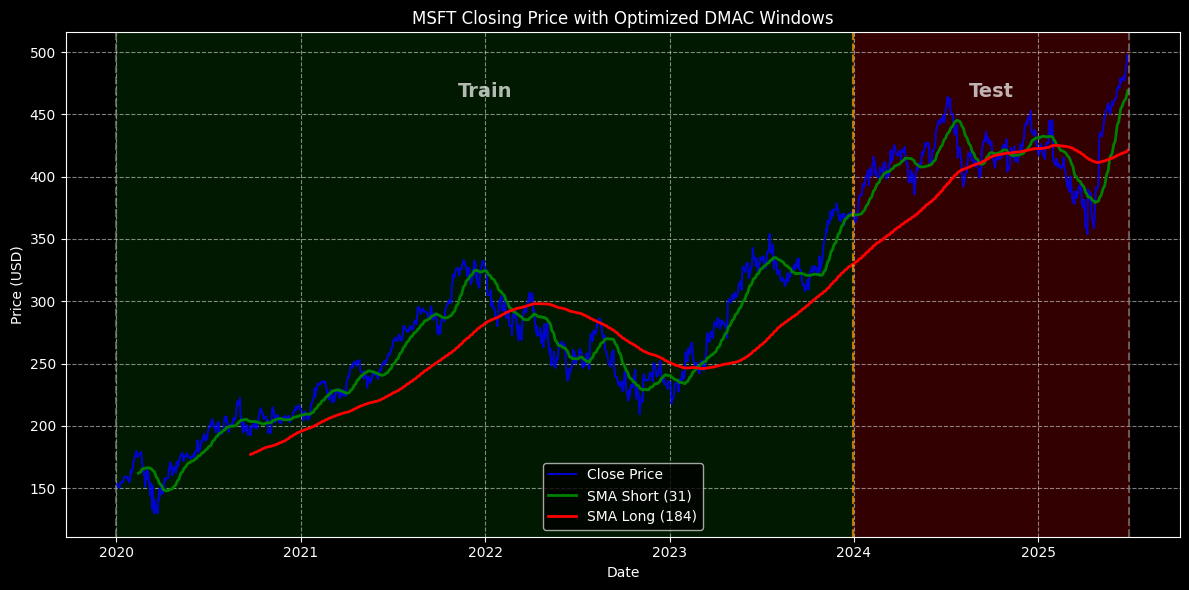

In [158]:
# Prepare data for plotting (using the entire dataset or test set)
plot_data = df.copy()
plot_data['SMA_Short'] = plot_data['Close'].rolling(best_short).mean()
plot_data['SMA_Long'] = plot_data['Close'].rolling(best_long).mean()

plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Close'], label='Close Price', color='blue', alpha=0.8)
plt.plot(plot_data.index, plot_data['SMA_Short'], label=f'SMA Short ({best_short})', color='green', linewidth=2)
plt.plot(plot_data.index, plot_data['SMA_Long'], label=f'SMA Long ({best_long})', color='red', linewidth=2)

# Convert string dates to datetime
start_dt = pd.to_datetime(start_date)
train_cutoff_dt = pd.to_datetime(train_cutoff_date)
end_dt = pd.to_datetime(end_date)

# Vertical cutoff lines
plt.axvline(start_dt, color='gray', linestyle='--', alpha=0.7)
plt.axvline(train_cutoff_dt, color='orange', linestyle='--', alpha=0.7)
plt.axvline(end_dt, color='gray', linestyle='--', alpha=0.7)

# Highlight train and test regions
plt.axvspan(start_dt, train_cutoff_dt, color='green', alpha=0.2)
plt.axvspan(train_cutoff_dt, end_dt, color='red', alpha=0.2)

# Text labels centered in train/test regions
train_mid = start_dt + (train_cutoff_dt - start_dt) / 2
test_mid = train_cutoff_dt + (end_dt - train_cutoff_dt) / 2
plt.text(train_mid, plt.ylim()[1]*0.9, 'Train', horizontalalignment='center', color='white', fontsize=14, fontweight='bold', alpha=0.7)
plt.text(test_mid, plt.ylim()[1]*0.9, 'Test', horizontalalignment='center', color='white', fontsize=14, fontweight='bold', alpha=0.7)

plt.title(f"{ticker} Closing Price with Optimized DMAC Windows")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("dmac_optimized_windows.png", dpi=300)
plt.show()

## Optimize RSI Mean Reversion

In [159]:
def rsi_objective(rsi_window, oversold, overbought):
    rsi_window = int(round(rsi_window))
    oversold = float(oversold)
    overbought = float(overbought)

    # Make sure oversold < overbought
    if oversold >= overbought:
        return -1e10

    try:
        result = backtest_rsi(df_train, rsi_window, oversold, overbought, initial_capital)
        result = result.dropna(subset=['Equity Curve'])  # <== Drop NaNs
        if result.empty:
            return -1e10
        return result['Equity Curve'].iloc[-1]
    except Exception as e:
        print("Error during optimization:", e)
        return -1e10

rsi_bo = BayesianOptimization(
    f=rsi_objective,
    pbounds={'rsi_window': (5, 30), 'oversold': (10, 40), 'overbought': (60, 90)},
    random_state=42,
    verbose=0
)
rsi_bo.maximize(init_points=5, n_iter=45)
rsi_best = rsi_bo.max['params']

print(f"Optimized RSI parameters found:")
print(f"  RSI Window: {int(round(rsi_best['rsi_window']))}")
print(f"  Oversold Level: {rsi_best['oversold']:.2f}")
print(f"  Overbought Level: {rsi_best['overbought']:.2f}")

Optimized RSI parameters found:
  RSI Window: 5
  Oversold Level: 40.00
  Overbought Level: 78.33


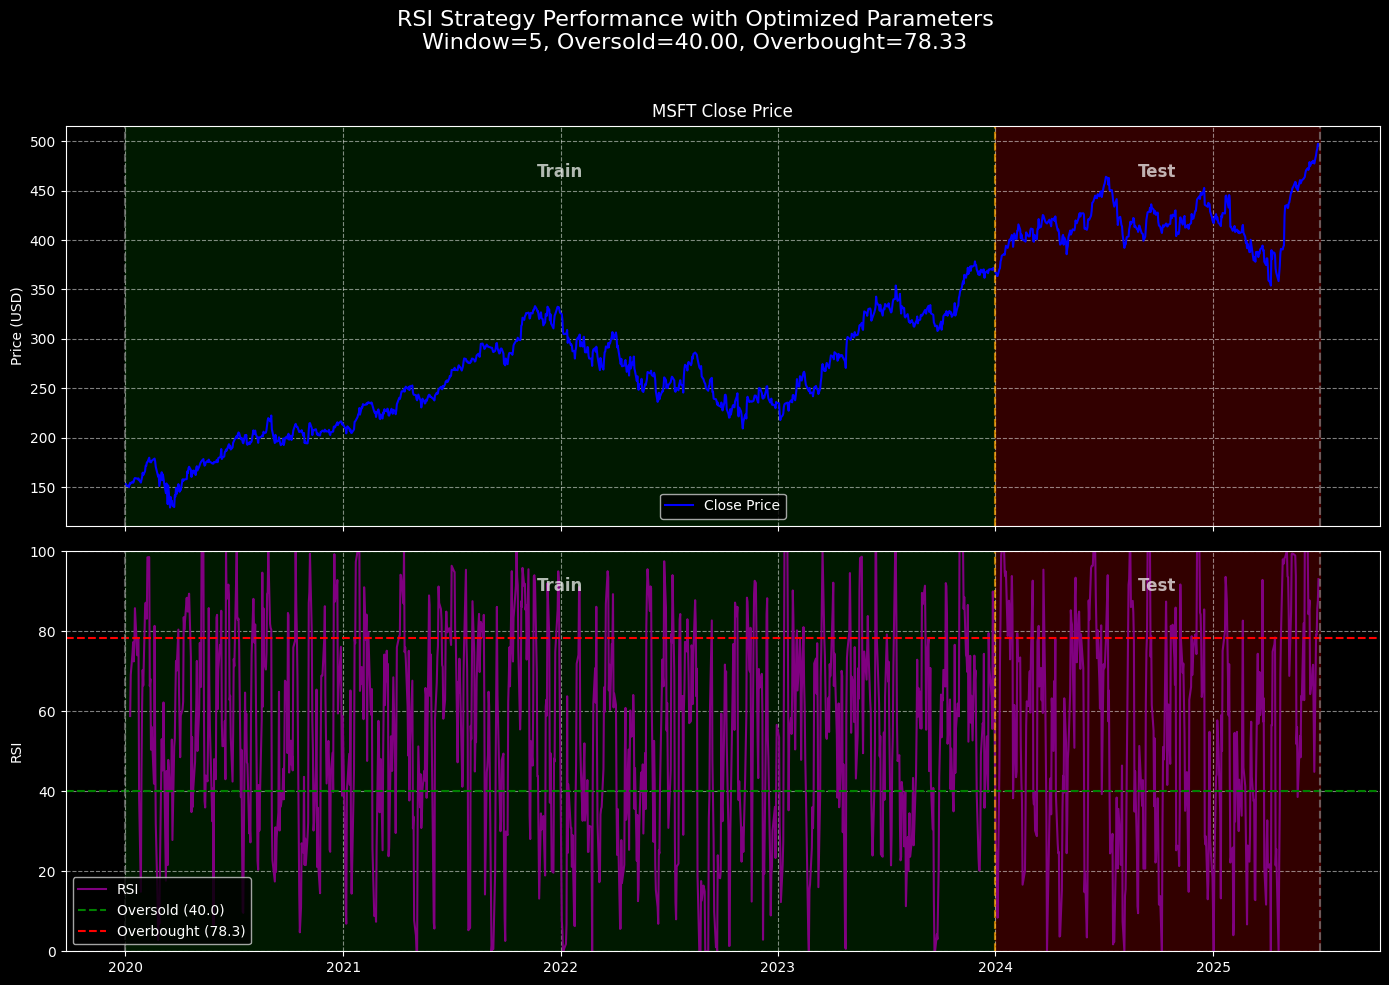

In [160]:
# Convert dates to datetime
start_dt = pd.to_datetime(start_date)
train_cutoff_dt = pd.to_datetime(train_cutoff_date)
end_dt = pd.to_datetime(end_date)

# Extract optimized params
opt_rsi_window = int(round(rsi_best['rsi_window']))
opt_oversold = rsi_best['oversold']
opt_overbought = rsi_best['overbought']

# Run backtest with optimized params on full df or test set
rsi_result = backtest_rsi(df.copy(), opt_rsi_window, opt_oversold, opt_overbought, initial_capital)

fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# 1. Plot Closing Price
axs[0].plot(rsi_result.index, rsi_result['Close'], label='Close Price', color='blue')
axs[0].set_title(f"{ticker} Close Price")
axs[0].set_ylabel("Price (USD)")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

# 2. Plot RSI with oversold/overbought lines and signals
axs[1].plot(rsi_result.index, rsi_result['RSI'], label='RSI', color='purple')
axs[1].axhline(opt_oversold, color='green', linestyle='--', label=f'Oversold ({opt_oversold:.1f})')
axs[1].axhline(opt_overbought, color='red', linestyle='--', label=f'Overbought ({opt_overbought:.1f})')
axs[1].set_ylabel("RSI")
axs[1].set_ylim(0, 100)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

# Add train/test overlays on all subplots
for ax in axs:
    ax.axvline(start_dt, color='gray', linestyle='--', alpha=0.7)
    ax.axvline(train_cutoff_dt, color='orange', linestyle='--', alpha=0.7)
    ax.axvline(end_dt, color='gray', linestyle='--', alpha=0.7)

    ax.axvspan(start_dt, train_cutoff_dt, color='green', alpha=0.2)
    ax.axvspan(train_cutoff_dt, end_dt, color='red', alpha=0.2)

    train_mid = start_dt + (train_cutoff_dt - start_dt) / 2
    test_mid = train_cutoff_dt + (end_dt - train_cutoff_dt) / 2
    ylim = ax.get_ylim()
    ax.text(train_mid, ylim[1]*0.9, 'Train', ha='center', color='white', fontsize=12, fontweight='bold', alpha=0.7)
    ax.text(test_mid, ylim[1]*0.9, 'Test', ha='center', color='white', fontsize=12, fontweight='bold', alpha=0.7)

plt.suptitle(
    f"RSI Strategy Performance with Optimized Parameters\n"
    f"Window={opt_rsi_window}, Oversold={opt_oversold:.2f}, Overbought={opt_overbought:.2f}",
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("rsi_optimized_performance.png", dpi=300)
plt.show()


## Apply Optimized Strategies on Test Set

In [161]:
# DMAC
dmac_test = backtest_dmac(
    df_test,
    short_window=round(dmac_best['short_window']),
    long_window=round(dmac_best['long_window']),
    capital=initial_capital
)

# RSI
rsi_test = backtest_rsi(
    df_test,
    rsi_window=round(rsi_best['rsi_window']),
    oversold=rsi_best['oversold'],
    overbought=rsi_best['overbought'],
    capital=initial_capital
)

## Compare Performance

In [162]:
def summarize_results(df, label):
    final_value = df['Equity Curve'].iloc[-1]
    return_pct = ((final_value / initial_capital) - 1) * 100
    trades = df['Position'].diff().abs().sum()
    return {
        "Strategy": label,
        "Final Value": final_value,
        "Return (%)": return_pct,
        "Trades": int(trades)
    }

# Calculate Buy & Hold summary based on df_test Close price
buy_hold_final_value = (df_test['Close'].iloc[-1] / df_test['Close'].iloc[0]) * initial_capital
buy_hold_return_pct = ((buy_hold_final_value / initial_capital) - 1) * 100

buy_hold_summary = {
    "Strategy": "Buy & Hold",
    "Final Value": buy_hold_final_value,
    "Return (%)": buy_hold_return_pct,
    "Trades": 0  # no trades for buy & hold
}

# Your existing summaries for DMAC and RSI
dmac_summary = summarize_results(dmac_test, "DMAC")
rsi_summary = summarize_results(rsi_test, "RSI Mean Reversion")

# Combine all summaries
summary_df = pd.DataFrame([dmac_summary, rsi_summary, buy_hold_summary])
summary_df


,Strategy,Final Value,Return (%),Trades
0,DMAC,7.789603,-22.103972,8
1,RSI Mean Reversion,11.645477,16.454769,133
2,Buy & Hold,13.524134,35.241341,0


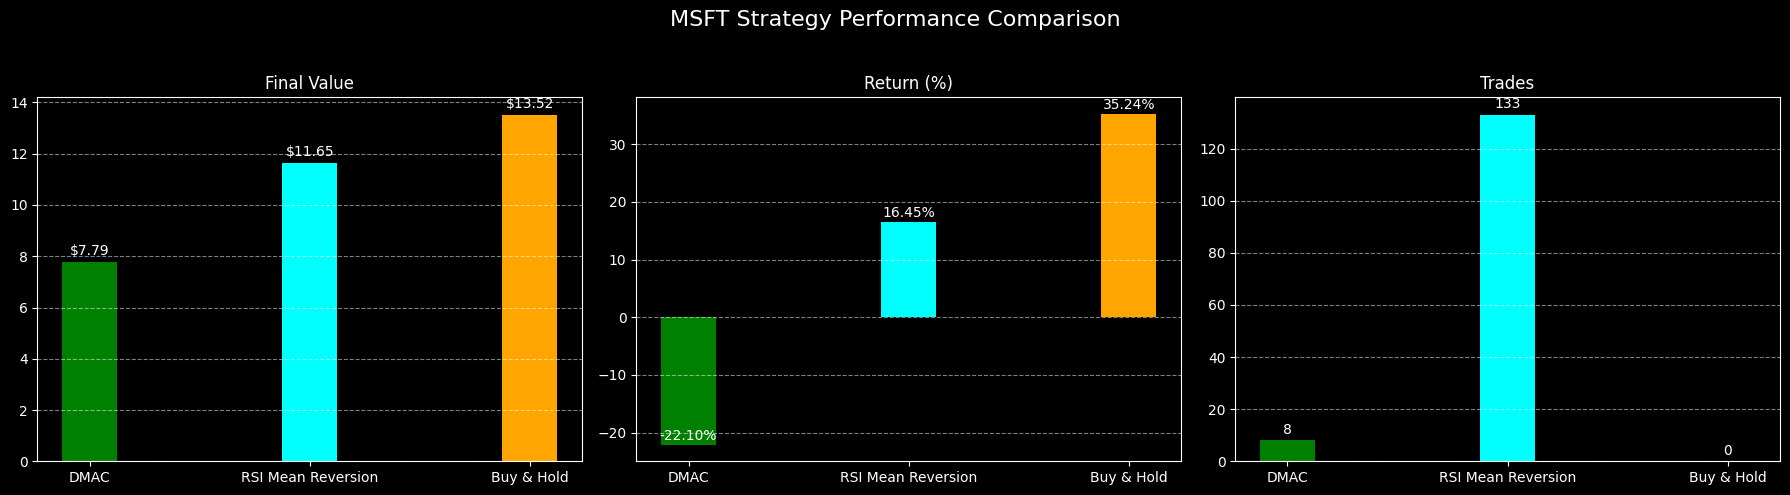

In [163]:
metrics = ['Final Value', 'Return (%)', 'Trades']
strategies = summary_df['Strategy'].values
values = summary_df[metrics].values.T  # shape: (3 metrics, 3 strategies)

x = np.arange(len(strategies))
width = 0.25

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    axs[i].bar(x, values[i], width, color=['green', 'cyan', 'orange'])
    axs[i].set_title(metric)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(strategies)
    axs[i].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Annotate bars with values
    for idx, val in enumerate(values[i]):
        if metric == 'Return (%)':
            axs[i].text(idx, val + max(values[i])*0.01, f"{val:.2f}%", ha='center', va='bottom', fontsize=10)
        elif metric == 'Final Value':
            axs[i].text(idx, val + max(values[i])*0.01, f"${val:.2f}", ha='center', va='bottom', fontsize=10)
        else:
            axs[i].text(idx, val + max(values[i])*0.01, f"{int(val)}", ha='center', va='bottom', fontsize=10)

plt.suptitle(f"{ticker} Strategy Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("strategy_performance_comparison.png", dpi=300)
plt.show()  

## Plot Equity Curves

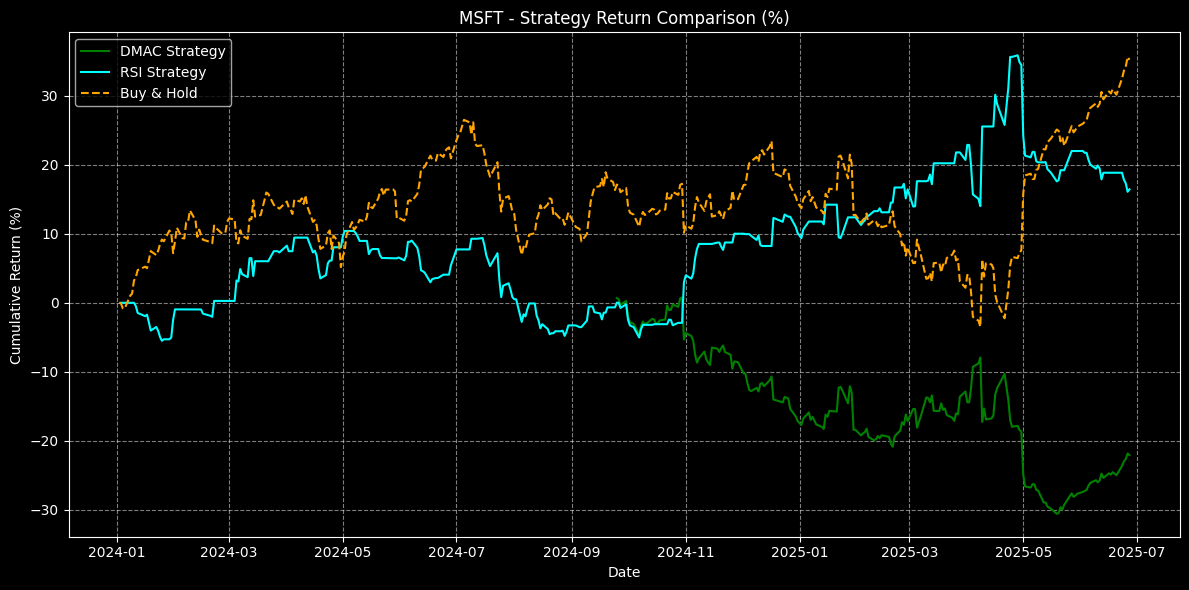

In [164]:
plt.figure(figsize=(12, 6))

# Normalize equity curves to start at 0%
dmac_pct = (dmac_test['Equity Curve'] / initial_capital - 1) * 100
rsi_pct = (rsi_test['Equity Curve'] / initial_capital - 1) * 100
buy_hold = (1 + df_test['Close'].pct_change().fillna(0)).cumprod()
buy_hold_pct = (buy_hold / buy_hold.iloc[0] - 1) * 100

# Plot percentage returns
plt.plot(dmac_test.index, dmac_pct, label='DMAC Strategy', color='green')
plt.plot(rsi_test.index, rsi_pct, label='RSI Strategy', color='cyan')
plt.plot(df_test.index, buy_hold_pct, label='Buy & Hold', color='orange', linestyle='--')

plt.title(f"{ticker} - Strategy Return Comparison (%)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("strategy_return_comparison.png", dpi=300)
plt.show()